In [1]:
%%time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Wall time: 8.39 s


## dacon 파일 열어보기
- 관련 링크: [Winner's Code](https://dacon.io/index.php?mid=code1&category=58792) / [competition](https://dacon.io/cpt9/145514)
- 2년 전 부터 2019년 2월 28일까지의 카드 거래 데이터를 이용해 2019-03-01부터 2019-05-31까지의 각 **상점별** 3개월 총 매출을 예측하는 것입니다.
- 상점별로 데이터를 구분해야 하나?
- 변수 설명
1. store_id : 상점의 고유 아이디
2. card_id : 사용한 카드의 고유 아이디
3. card_company : 비식별화된 카드 회사
4. trasacted_date : 거래 날짜
5. transacted_time : 거래 시간( 시:분 ) **24시간으로 되어 있음**
6. installment_term : 할부 개월 수( 포인트 사용 시 (60개월 + 실제할부개월)을 할부개월수에 기재한다. )
7. region : 상점의 지역
8. type_of_business : 상점의 업종
9. amount : 거래액(단위는 원이 아닙니다)

In [2]:
%%time
data = pd.read_csv('../datasets/funda_train.csv')
#data['transacted_date'] = pd.to_datetime(data['transacted_date']) # 9.66s
#data['transacted_date'] = pd.to_datetime(data['transacted_date']).dt.date # 12.1ㄴ
#위 코드는 형식이 다시 object가 됨
print(data.shape) # 655,6613 * 9

(6556613, 9)
Wall time: 11.7 s


In [3]:
data.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


In [39]:
for column in data:
    print(column, "| ex:", data[column][123232], "|", data[column].dtype)

store_id | ex: 33 | int64
card_id | ex: 88203 | int64
card_company | ex: a | object
transacted_date | ex: 2018-10-04 | object
transacted_time | ex: 17:14 | object
installment_term | ex: 0 | int64
region | ex: 서울 마포구 | object
type_of_business | ex: 한식 음식점업 | object
amount | ex: 1857.142857142857 | float64


## 변수 정리
- 숫자형(int, float) 4개: store_id, card_id, installment_term, amount
- 문자형(object) 3개: card_company, region, type_of_business
- date or time 2개: trans_date, trans_time

In [4]:
print(data.store_id.max()) #최대값 2136
print(data.store_id.min()) #최소값 0
print(len(data.store_id.unique())) #1967개 store_id

2136
0
1967


In [28]:
print(len(data.store_id.unique())) #1967개 store
print(data.store_id.value_counts().head()) # 한 store는 최대 9518개 count

1967
1330    9518
1196    9471
1171    9391
710     9347
826     9328
Name: store_id, dtype: int64


In [29]:
print(data.region.isnull().value_counts())
data.corr()

False    4513847
True     2042766
Name: region, dtype: int64


,store_id,card_id,installment_term,amount
store_id,1.000000,0.969906,-0.014859,-0.039063
card_id,0.969906,1.000000,-0.013424,-0.038116
installment_term,-0.014859,-0.013424,1.000000,0.212325
amount,-0.039063,-0.038116,0.212325,1.000000


- store_id와 card_id는 매우 강한 상관관계(0.97)
- 할부기간과 거래액(amount)는 약한 상관관계(0.21)

In [61]:
# 날짜별 거래 건수 구하기
date_value = pd.DataFrame([data.transacted_date.value_counts().index, data.transacted_date.value_counts()]).T

In [62]:
date_value.columns = ['date', 'count']
date_value = date_value.sort_values(by='date')-
date_value['date'] = pd.to_datetime(date_value['date'])
#연도별로 나누기 위해 year 칼럼 추가
date_value['year'] = pd.DatetimeIndex(date_value['date']).year
date_value.head()

,date,count,year
903,2016-06-01,4789,2016
872,2016-06-02,4953,2016
841,2016-06-03,5122,2016
757,2016-06-04,5544,2016
972,2016-06-05,4060,2016


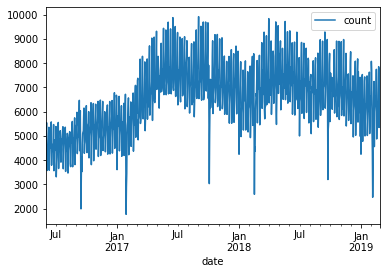

In [47]:
date_value.plot(x = "date", y = "count")

### 연도별로 나눠보기
[참고한 사이트](https://www.interviewqs.com/ddi_code_snippets/extract_month_year_pandas)

In [65]:
for year in range(2016, 2020):
    globals()['counts_{}'.format(year)] = date_value[date_value['year'] == year]

counts_2016.head()

,date,count,year
903,2016-06-01,4789,2016
872,2016-06-02,4953,2016
841,2016-06-03,5122,2016
757,2016-06-04,5544,2016
972,2016-06-05,4060,2016


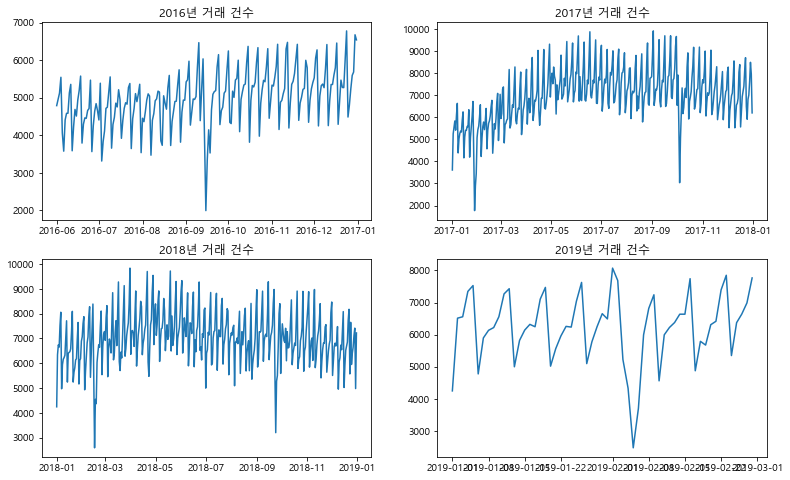

In [77]:
# 4개 년도 데이터를 subplot으로 그려보기
plt.rc('font', family = "malgun gothic")
fig = plt.figure(figsize = (13,8))

ax1 = fig.add_subplot(2,2,1)
plt.title("2016년 거래 건수")
plt.plot(counts_2016['date'], counts_2016['count'])

ax2 = fig.add_subplot(2,2,2)
plt.title("2017년 거래 건수")
plt.plot(counts_2017['date'], counts_2017['count'])

ax3 = fig.add_subplot(2,2,3)
plt.title("2018년 거래 건수")
plt.plot(counts_2018['date'], counts_2018['count'])

ax4 = fig.add_subplot(2,2,4)
plt.title("2019년 거래 건수")
plt.plot(counts_2019['date'], counts_2019['count'])

## 연도별로 저점 찍은 날짜 -> 명절 당일
- 예측해야 할 구간(2019.3.1 ~ 5.31)에 명절은 없으므로 예측에 상관은 없을 듯함.
- 다만 다른 공휴일들은 어떤 패턴인지 찾아보기

In [84]:
# 이렇게 조건으로 인덱싱하는거 더 간편한거 없나? apply 같은.
print(counts_2016[counts_2016['count'] == counts_2016['count'].min()])
print(counts_2017[counts_2017['count'] == counts_2017['count'].min()])
print(counts_2018[counts_2018['count'] == counts_2018['count'].min()])
print(counts_2019[counts_2019['count'] == counts_2019['count'].min()])

           date count  year
1001 2016-09-15  1993  2016
           date count  year
1002 2017-01-28  1769  2017
          date count  year
999 2018-02-16  2592  2018
           date count  year
1000 2019-02-05  2472  2019


## 월 안에서 그래프 봐보기

In [95]:
date_value['month'] = pd.DatetimeIndex(date_value['date']).month
date_value['day'] = pd.DatetimeIndex(date_value['date']).day
date_value.head()

,date,count,year,month,day
903,2016-06-01,4789,2016,6,1
872,2016-06-02,4953,2016,6,2
841,2016-06-03,5122,2016,6,3
757,2016-06-04,5544,2016,6,4
972,2016-06-05,4060,2016,6,5


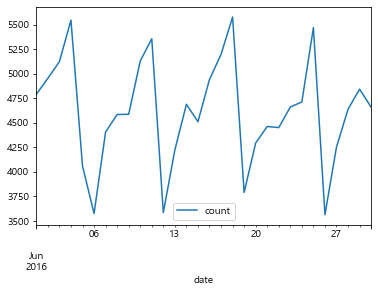

In [97]:
june = date_value[(date_value['year'] == 2016) & (date_value['month'] == 6)]
june.head()

june.plot(x = "date", y = "count") #요일별로 명확한 차이.

# 8/2 여기까지 함.
>이제 RNN 시차를 7일로 할지(전 주 같은 요일), 요일별로 묶어 학습할지 등 생각해 보기
- 요일은 Monday 이런 식으로 바꿔보기? 이전에 했던거 참고(롯데)

In [32]:
#열별로 null 개수 세기 -> region, type_of_business만 null 값이 있음
print(data['region'].isnull().value_counts())
print(data['type_of_business'].isnull().value_counts())

False    4513847
True     2042766
Name: region, dtype: int64
True     3952609
False    2604004
Name: type_of_business, dtype: int64


## store 별 변수 할당하기

In [ ]:
%%time
for i in range(len(data.store_id.unique())):
    globals()['id_{}'.format(i)] = data[data.store_id == i]

In [113]:
id_293.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
837701,293,555014,d,2016-06-01,00:51,0,인천 남동구,NaN,6785.714286
837702,293,555015,b,2016-06-01,01:14,0,인천 남동구,NaN,2857.142857
837703,293,555016,h,2016-06-01,21:34,0,인천 남동구,NaN,6142.857143
837704,293,555017,b,2016-06-01,21:44,0,인천 남동구,NaN,5428.571429
837705,293,555018,b,2016-06-01,22:13,0,인천 남동구,NaN,5285.714286


## 1-1. Data 기본 탐색
16-6-1 ~ 19.2.28까지의 데이터이므로, 일단 18.12.28까지를 train으로 해 보기

In [149]:
data.transacted_date.head()

0    2016-06-01
1    2016-06-01
2    2016-06-01
3    2016-06-01
4    2016-06-02
Name: transacted_date, dtype: object

## 1-2. Sequence 길이 정하기

In [143]:
data['store_id'].value_counts().describe()

count    1967.000000
mean     3333.306050
std      2497.181711
min        72.000000
25%      1153.000000
50%      2516.000000
75%      5093.500000
max      9518.000000
Name: store_id, dtype: float64